# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

from scipy.linalg import eigh # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [3]:
# Standard and Poor's 500 - S&P 500 (United States)
df_stock_index = pd.read_pickle("{}/df_sp500_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Example for Mutual Information

In [4]:
x = [0.5, 0.5]
y = [0.1, 0.9]

joint_xx = [0.25, 0.25, 0.25, 0.25]
joint_xy = [0.05, 0.45, 0.05, 0.45]
joint_yx = [0.05, 0.05, 0.45, 0.45]
joint_yy = [0.01, 0.09, 0.09, 0.81]
joint_proof = [0.1, 0.2, 0.3, 0.4]


print(mf.estimate_renyi_entropy(x = x, p = 1))
print(mf.estimate_renyi_entropy(x = y, p = 1))
print(mf.estimate_renyi_entropy(x = x, p = 1) + mf.estimate_renyi_entropy(x = y, p = 1))
print("")
print(mf.estimate_mutual_information(x = x, y = x, joint_xy = joint_xx))
print(mf.estimate_mutual_information(x = x, y = y, joint_xy = joint_xy))
print(mf.estimate_mutual_information(x = y, y = x, joint_xy = joint_yx))
print(mf.estimate_mutual_information(x = y, y = y, joint_xy = joint_yy))
print("")
print(mf.estimate_shared_information_distance(x = x, y = x, joint_xy = joint_xx) / 2)
print(mf.estimate_shared_information_distance(x = x, y = y, joint_xy = joint_xy))
print(mf.estimate_shared_information_distance(x = y, y = x, joint_xy = joint_yx))
print(mf.estimate_shared_information_distance(x = y, y = y, joint_xy = joint_yy) / 2)
print("")
print(mf.estimate_mutual_information(x = x, y = x, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = x, y = y, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = y, y = x, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = y, y = y, joint_xy = joint_proof))
print("")
print(mf.estimate_shared_information_distance(x = x, y = x, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = x, y = y, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = y, y = x, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = y, y = y, joint_xy = joint_proof))



0.6931471805599453
0.3250829733914482
1.0182301539513934

0
-2.220446049250313e-16
-2.220446049250313e-16
0

0.6931471805599453
1.0182301539513938
1.0182301539513938
0.3250829733914482

0
-0.2616240718822742
-0.2616240718822742
0

1.2798542258336676
1.5414782977159418
1.5414782977159418
1.2798542258336676


## Entropy matrix

In [5]:
def binning_info_pairs(df, symbol_x, symbol_y, bins_x, bins_y, precision=12):
    # Normalize variables for correct and comparable binningg
    df_binning = (
        df[df["symbol"].isin([symbol_x, symbol_y])][["date", "symbol", "normalized_log_return"]]
            .pivot(index = "date", columns = "symbol", values = "normalized_log_return")
            .reset_index()
    )

    df_binning[symbol_x] = (df_binning[symbol_x] - df_binning[symbol_x].min()) / (df_binning[symbol_x].max() - df_binning[symbol_x].min())
    df_binning[symbol_y] = (df_binning[symbol_y] - df_binning[symbol_y].min()) / (df_binning[symbol_y].max() - df_binning[symbol_y].min())

    # Binning data
    df_binning["bin_x"] = pd.cut(
        df_binning[symbol_x],
        bins = np.linspace(0, 1, num = bins_x + 1),
        include_lowest = True,
        labels = ["".join(("category_", str(z + 1).zfill(int(np.log10(bins_x)) + 1))) for z in range(bins_x)],
        precision = precision
    )

    df_binning["bin_y"] = pd.cut(
        df_binning[symbol_y],
        bins = np.linspace(0, 1, num = bins_y + 1),
        include_lowest = True,
        labels = ["".join(("category_", str(z + 1).zfill(int(np.log10(bins_y)) + 1))) for z in range(bins_y)],
        precision = precision
    )

    # Histogram data
    df_1 = (
        df_binning[["bin_x"]]
            .value_counts(sort = False, normalize = True)
            .reset_index()
            .rename(columns = {"proportion" : "prob_x"})
            .sort_values(["bin_x"])
    )

    df_2 = (
        df_binning[["bin_y"]]
            .value_counts(sort = False, normalize = True)
            .reset_index()
            .rename(columns = {"proportion" : "prob_y"})
            .sort_values(["bin_y"])
    )

    df_3 = (
        df_binning[["bin_x", "bin_y"]]
            .value_counts(sort = False, normalize = True)
            .reset_index()
            .rename(columns = {"proportion" : "joint_xy"})
            .sort_values(["bin_x", "bin_y"])
    )

    return df_1, df_2, df_3


def estimate_shared_info_pairs(df, symbol_x, symbol_y, bins_x, bins_y, precision=12):
    df_1, df_2, df_3 = binning_info_pairs(
        df = df_stock_index,
        symbol_x = symbol_x,
        symbol_y = symbol_y,
        bins_x = bins_x,
        bins_y = bins_y,
        precision = precision
    )

    # Entropy estimation
    hx = mf.estimate_renyi_entropy(x = df_1["prob_x"], p = 1)
    hy = mf.estimate_renyi_entropy(x = df_2["prob_y"], p = 1)
    hxy = mf.estimate_renyi_entropy(x = df_3["joint_xy"], p = 1)
    
    x_ = df_1["prob_x"].values
    y_ = df_2["prob_y"].values
    joint_xy = df_3["joint_xy"].values

    mi_xx = mf.estimate_mutual_information(x = x_, y = x_, joint_xy = joint_xy)
    mi_xy = mf.estimate_mutual_information(x = x_, y = y_, joint_xy = joint_xy)
    mi_yx = mf.estimate_mutual_information(x = y_, y = x_, joint_xy = joint_xy)
    mi_yy = mf.estimate_mutual_information(x = y_, y = y_, joint_xy = joint_xy)
    
    si_xx = mf.estimate_shared_information_distance(x = x_, y = x_, joint_xy = joint_xy)
    si_xy = mf.estimate_shared_information_distance(x = x_, y = y_, joint_xy = joint_xy)
    si_yx = mf.estimate_shared_information_distance(x = y_, y = x_, joint_xy = joint_xy)
    si_yy = mf.estimate_shared_information_distance(x = y_, y = y_, joint_xy = joint_xy)

    # Final information
    df_final = pd.DataFrame(
        {
            "symbol_x" : [symbol_x, symbol_x, symbol_y, symbol_y],
            "symbol_y" : [symbol_x, symbol_y, symbol_x, symbol_y],
            "entropy_x" : [hx, hx, hx, hx],
            "entropy_y" : [hy, hy, hy, hy],
            "joint_entropy" : [hxy, hxy, hxy, hxy],
            "mutual_information" : [mi_xx, mi_xy, mi_yx, mi_yy],
            "shared_information" : [si_xx, si_xy, si_yx, si_yy]
        }
    )
    df_final["modified_jaccard_distance"] = df_final["shared_information"] / df_final["joint_entropy"]

    return df_final, df_1, df_2, df_3


In [6]:
estimate_shared_info_pairs(df = df_stock_index, symbol_x = "MMM", symbol_y = "ZTS", bins_x = 76, bins_y = 50, precision = 12)[0]


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,modified_jaccard_distance
0,MMM,MMM,2.80137,2.391416,4.832951,0.000000,4.832951,1.000000
1,MMM,ZTS,2.80137,2.391416,4.832951,0.359834,4.473117,0.925546
2,ZTS,MMM,2.80137,2.391416,4.832951,0.359834,4.473117,0.925546
3,ZTS,ZTS,2.80137,2.391416,4.832951,0.000000,4.832951,1.000000


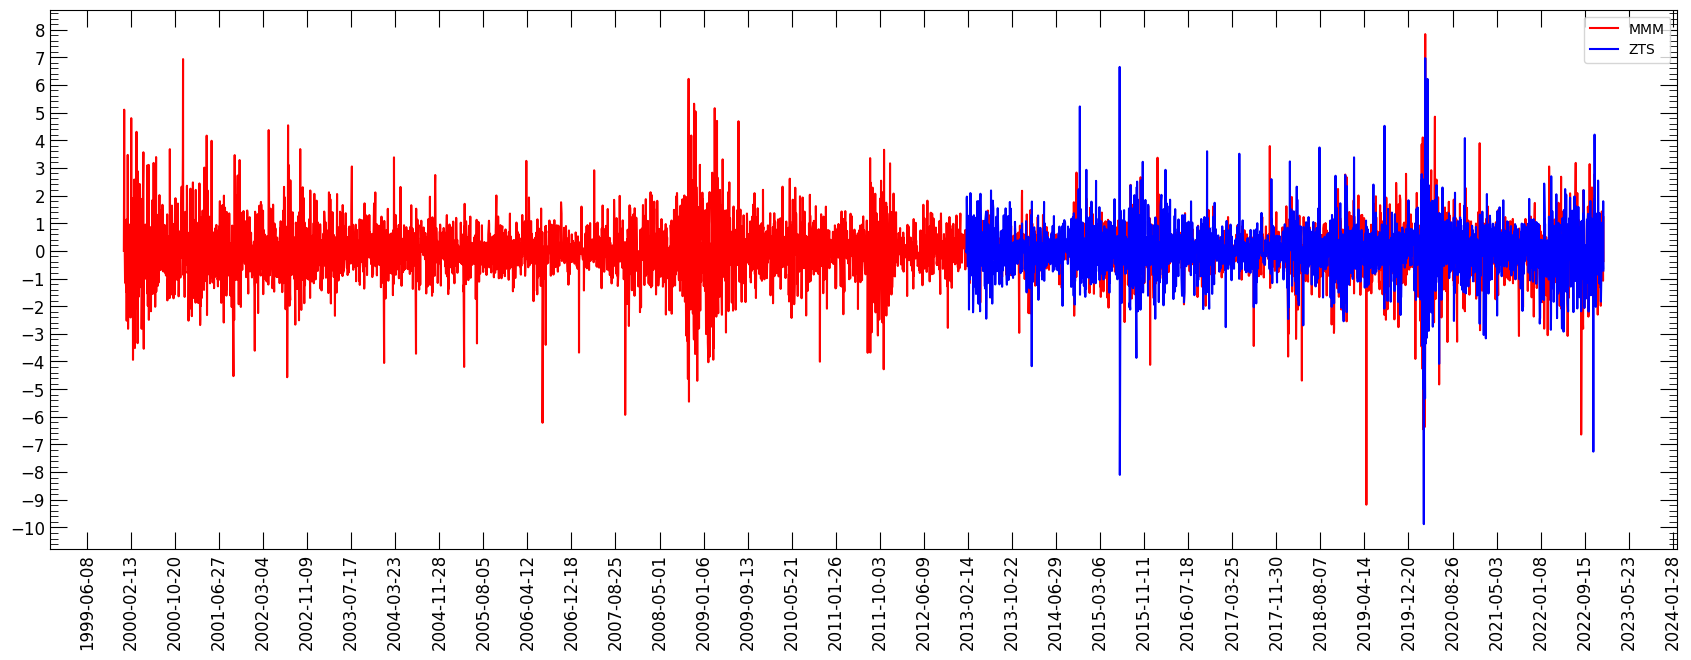

In [7]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 7)

df_1 = df_stock_index[df_stock_index["symbol"] == "MMM"]
df_2 = df_stock_index[df_stock_index["symbol"] == "ZTS"]

ax.plot(df_1["date"], df_1["normalized_log_return"], color = "red", label = "MMM")
ax.plot(df_2["date"], df_2["normalized_log_return"], color = "blue", label = "ZTS")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax.xaxis.set_major_locator(mtick.MaxNLocator(40))
#ax.xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax.yaxis.set_major_locator(mtick.MaxNLocator(20))
ax.yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend()
plt.show()


## Construct covariance matrix and compare with entropy matrix

In [ ]:
df_cov = get_fts.estimate_covariance_stock_index(df = df_stock_index, normalized = True)
df_cov

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,AVB,AVGO,AVY,AWK,AXON,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BG,BIIB,BIO,BK,BKNG,BKR,BLDR,BLK,BMY,BR,BRO,BSX,BWA,BX,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CEG,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COR,COST,CPAY,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DAY,DD,DE,DECK,DFS,DG,DGX,DHI,DHR,DIS,DLR,DLTR,DOC,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXCM,EA,EBAY,ECL,ED,EFX,EG,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FI,FICO,FIS,FITB,FMC,FOX,FOXA,FRT,FSLR,FTNT,FTV,GD,GE,GEHC,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUBB,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JBL,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNT,LOW,LRCX,LULU,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PANW,PARA,PAYC,PAYX,PCAR,PCG,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PLD,PM,PNC,PNR,PNW,PODD,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PYPL,QCOM,QRVO,RCL,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,RVTY,SBAC,SBUX,SCHW,SHW,SJM,SLB,SMCI,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UBER,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VICI,VLO,VMC,VRSK,VRSN,VRTX,VST,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
0,1.000000,0.270331,0.374139,0.250138,0.270730,0.257290,0.270597,0.392156,0.441361,0.542878,0.279985,0.388259,0.445504,0.257730,0.228641,0.261865,0.328343,0.260603,0.320555,0.276484,0.389852,0.386471,0.278595,0.330025,0.335523,0.496878,0.227024,0.418477,0.442008,0.324586,0.431333,0.349725,0.362184,0.269108,0.385057,0.264906,0.365936,0.259166,0.398398,0.490832,0.299957,0.335823,0.288216,0.306161,0.355295,0.364580,0.295581,0.242270,0.406364,0.262505,0.333811,0.347418,0.342296,0.234380,0.304800,0.348736,0.306251,0.428446,0.260633,0.299815,0.321343,0.384835,0.340689,0.281473,0.302792,0.378657,0.248674,0.390973,0.320976,0.324470,0.387238,0.399122,0.315983,0.369510,0.174888,0.251872,0.288227,0.421810,0.311999,0.233594,0.359396,0.360121,0.310133,0.435062,0.319298,0.410554,0.324516,0.286361,0.282331,0.225570,0.318127,0.250632,0.276254,0.348590,0.209077,0.171708,0.333801,0.360103,0.303355,0.259628,0.422734,0.241640,0.241921,0.187148,0.372309,0.294821,0.291883,0.211603,0.327471,0.316989,0.167855,0.310792,0.314616,0.315913,0.360758,0.493231,0.349601,0.380280,0.409361,0.318234,0.260917,0.391850,0.305305,0.267565,0.324755,0.228850,0.239427,0.286681,0.369857,0.388207,0.385329,0.217751,0.372334,0.204158,0.260558,0.342915,0.488612,0.411686,0.305722,0.225161,0.279417,0.473574,0.334812,0.258654,0.243833,0.271818,0.210079,0.245656,0.257759,0.274234,0.331991,0.395199,0.367104,0.181243,0.374399,0.297759,0.170144,0.316375,0.279063,0.388652,0.434410,0.176832,0.276194,0.270062,0.254365,0.297614,0.236372,0.272617,0.308854,0.474248,0.175967,0.239353,0.263884,0.265176,0.236948,0.355420,0.284827,0.331786,0.316088,0.174885,0.388579,0.311842,0.374700,0.361384,0.224512,0.392375,0.383368,0.350835,0.331245,0.289901,0.367541,0.260898,0.243739,0.293519,0.280161,0.295692,0.362833,0.342415,0.382749,0.065852,0.312359,0.329530,0.173231,0.362567,0.441137,0.317328,0.296422,0.339824,0.340788,0.375087,0.352674,0.316363,0.438734,0.36430

In [ ]:
df_cov["symbol"] = df_cov.columns
df_cov

symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,AON,AOS,APA,APD,APH,APTV,ARE,ATO,AVB,AVGO,AVY,AWK,AXON,AXP,AZO,BA,BAC,BALL,BAX,BBWI,BBY,BDX,BEN,BG,BIIB,BIO,BK,BKNG,BKR,BLDR,BLK,BMY,BR,BRO,BSX,BWA,BX,BXP,C,CAG,CAH,CARR,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CEG,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COO,COP,COR,COST,CPAY,CPB,CPRT,CPT,CRL,CRM,CSCO,CSGP,CSX,CTAS,CTLT,CTRA,CTSH,CTVA,CVS,CVX,CZR,D,DAL,DAY,DD,DE,DECK,DFS,DG,DGX,DHI,DHR,DIS,DLR,DLTR,DOC,DOV,DOW,DPZ,DRI,DTE,DUK,DVA,DVN,DXCM,EA,EBAY,ECL,ED,EFX,EG,EIX,EL,ELV,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETN,ETR,ETSY,EVRG,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FCX,FDS,FDX,FE,FFIV,FI,FICO,FIS,FITB,FMC,FOX,FOXA,FRT,FSLR,FTNT,FTV,GD,GE,GEHC,GEN,GILD,GIS,GL,GLW,GM,GNRC,GOOG,GOOGL,GPC,GPN,GRMN,GS,GWW,HAL,HAS,HBAN,HCA,HD,HES,HIG,HII,HLT,HOLX,HON,HPE,HPQ,HRL,HSIC,HST,HSY,HUBB,HUM,HWM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,IT,ITW,IVZ,J,JBHT,JBL,JCI,JKHY,JNJ,JNPR,JPM,K,KDP,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,L,LDOS,LEN,LH,LHX,LIN,LKQ,LLY,LMT,LNT,LOW,LRCX,LULU,LUV,LVS,LW,LYB,LYV,MA,MAA,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,META,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOH,MOS,MPC,MPWR,MRK,MRNA,MRO,MS,MSCI,MSFT,MSI,MTB,MTCH,MTD,MU,NCLH,NDAQ,NDSN,NEE,NEM,NFLX,NI,NKE,NOC,NOW,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWS,NWSA,NXPI,O,ODFL,OKE,OMC,ON,ORCL,ORLY,OTIS,OXY,PANW,PARA,PAYC,PAYX,PCAR,PCG,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PLD,PM,PNC,PNR,PNW,PODD,POOL,PPG,PPL,PRU,PSA,PSX,PTC,PWR,PYPL,QCOM,QRVO,RCL,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTX,RVTY,SBAC,SBUX,SCHW,SHW,SJM,SLB,SMCI,SNA,SNPS,SO,SPG,SPGI,SRE,STE,STLD,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TDY,TECH,TEL,TER,TFC,TFX,TGT,TJX,TMO,TMUS,TPR,TRGP,TRMB,TROW,TRV,TSCO,TSLA,TSN,TT,TTWO,TXN,TXT,TYL,UAL,UBER,UDR,UHS,ULTA,UNH,UNP,UPS,URI,USB,V,VICI,VLO,VMC,VRSK,VRSN,VRTX,VST,VTR,VTRS,VZ,WAB,WAT,WBA,WBD,WDC,WEC,WELL,WFC,WM,WMB,WMT,WRB,WRK,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS,symbol
0,1.000000,0.270331,0.374139,0.250138,0.270730,0.257290,0.270597,0.392156,0.441361,0.542878,0.279985,0.388259,0.445504,0.257730,0.228641,0.261865,0.328343,0.260603,0.320555,0.276484,0.389852,0.386471,0.278595,0.330025,0.335523,0.496878,0.227024,0.418477,0.442008,0.324586,0.431333,0.349725,0.362184,0.269108,0.385057,0.264906,0.365936,0.259166,0.398398,0.490832,0.299957,0.335823,0.288216,0.306161,0.355295,0.364580,0.295581,0.242270,0.406364,0.262505,0.333811,0.347418,0.342296,0.234380,0.304800,0.348736,0.306251,0.428446,0.260633,0.299815,0.321343,0.384835,0.340689,0.281473,0.302792,0.378657,0.248674,0.390973,0.320976,0.324470,0.387238,0.399122,0.315983,0.369510,0.174888,0.251872,0.288227,0.421810,0.311999,0.233594,0.359396,0.360121,0.310133,0.435062,0.319298,0.410554,0.324516,0.286361,0.282331,0.225570,0.318127,0.250632,0.276254,0.348590,0.209077,0.171708,0.333801,0.360103,0.303355,0.259628,0.422734,0.241640,0.241921,0.187148,0.372309,0.294821,0.291883,0.211603,0.327471,0.316989,0.167855,0.310792,0.314616,0.315913,0.360758,0.493231,0.349601,0.380280,0.409361,0.318234,0.260917,0.391850,0.305305,0.267565,0.324755,0.228850,0.239427,0.286681,0.369857,0.388207,0.385329,0.217751,0.372334,0.204158,0.260558,0.342915,0.488612,0.411686,0.305722,0.225161,0.279417,0.473574,0.334812,0.258654,0.243833,0.271818,0.210079,0.245656,0.257759,0.274234,0.331991,0.395199,0.367104,0.181243,0.374399,0.297759,0.170144,0.316375,0.279063,0.388652,0.434410,0.176832,0.276194,0.270062,0.254365,0.297614,0.236372,0.272617,0.308854,0.474248,0.175967,0.239353,0.263884,0.265176,0.236948,0.355420,0.284827,0.331786,0.316088,0.174885,0.388579,0.311842,0.374700,0.361384,0.224512,0.392375,0.383368,0.350835,0.331245,0.289901,0.367541,0.260898,0.243739,0.293519,0.280161,0.295692,0.362833,0.342415,0.382749,0.065852,0.312359,0.329530,0.173231,0.362567,0.441137,0.317328,0.296422,0.339824,0.340788,0.375087,0.352674,0.316363,0.438734,

In [ ]:
A = df_cov[df_cov["symbol"].str.contains("Z")]
A[A.symbol]

symbol,AIZ,AMZN,AZO,CZR,DPZ,IVZ,MDLZ,STZ,VZ,ZBH,ZBRA,ZTS
18,1.000000,0.234901,0.296099,0.321501,0.283679,0.538976,0.347923,0.316716,0.337403,0.365495,0.303348,0.297891
32,0.234901,1.000000,0.248411,0.216612,0.248761,0.331204,0.179530,0.170897,0.226443,0.216320,0.304520,0.256602
49,0.296099,0.248411,1.000000,0.258938,0.284751,0.361302,0.278995,0.278693,0.291667,0.272828,0.254048,0.316410
125,0.321501,0.216612,0.258938,1.000000,0.140587,0.379344,0.241040,0.307644,0.118272,0.457538,0.379106,0.360143
143,0.283679,0.248761,0.284751,0.140587,1.000000,0.316467,0.252181,0.237705,0.228307,0.246006,0.264739,0.216437
252,0.538976,0.331204,0.361302,0.379344,0.316467,1.000000,0.360642,0.354466,0.408587,0.397347,0.398004,0.335134
299,0.347923,0.179530,0.278995,0.241040,0.252181,0.360642,1.000000,0.283170,0.325037,0.298171,0.262214,0.419900
420,0.316716,0.170897,0.278693,0.307644,0.237705,0.354466,0.283170,1.000000,0.264241,0.321482,0.237506,0.296876
472,0.337403,0.226443,0.291667,0.118272,0.228307,0.408587,0.325037,0.264241,1.000000,0.264821,0.231679,0.231561
494,0.365495,0.216320,0.272828,0.457538,0.246006,0.397347,0.298171,0.321482,0.264821,1.000000,0.302163,0.400155


In [8]:
df_symbols = df_stock_index[["symbol"]].sort_values(["symbol"]).value_counts(sort = False).reset_index().rename(columns = {"count" : "bin_value"})
df_symbols["bin_value"] = df_symbols["bin_value"].apply(lambda x: int(np.sqrt(x)))
df_symbols = df_symbols[df_symbols["symbol"].str.contains("Z")]
df_symbols


,symbol,bin_value
18,AIZ,68
32,AMZN,75
49,AZO,75
125,CZR,45
143,DPZ,67
252,IVZ,75
299,MDLZ,73
420,STZ,75
472,VZ,75
494,ZBH,73


In [41]:
df_stock_entropy = pd.DataFrame()
for i, symbol_1 in enumerate(df_symbols["symbol"]):
    bins_1 = df_symbols[df_symbols["symbol"] == symbol_1]["bin_value"].values[0]
    for j, symbol_2 in enumerate(df_symbols["symbol"]):
        if i <= j:
            bins_2 = df_symbols[df_symbols["symbol"] == symbol_2]["bin_value"].values[0]
            df_stock_entropy = df_stock_entropy._append(
                estimate_shared_info_pairs(
                    df = df_stock_index,
                    symbol_x = symbol_1,
                    symbol_y = symbol_2,
                    bins_x = bins_1,
                    bins_y = bins_2,
                    precision = 12
                )[0]
            )

            #print("N1: {}, Symbol: {}, N2: {}, Symbol: {}".format(i, symbol_1, j, symbol_2))
        
df_stock_entropy[df_stock_entropy["symbol_x"] != df_stock_entropy["symbol_y"]].drop_duplicates().sort_values(["modified_jaccard_distance"], ascending = False)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,modified_jaccard_distance
2,VZ,STZ,2.336058,2.788050,4.987837,0.136271,4.851567,0.972679
1,STZ,VZ,2.336058,2.788050,4.987837,0.136271,4.851567,0.972679
2,STZ,AMZN,2.625669,2.336058,4.821485,0.140242,4.681243,0.970913
1,AMZN,STZ,2.625669,2.336058,4.821485,0.140242,4.681243,0.970913
1,VZ,ZBRA,2.788050,2.601857,5.236262,0.153645,5.082617,0.970658
...,...,...,...,...,...,...,...,...
1,CZR,IVZ,1.972942,2.774797,4.346647,0.401092,3.945555,0.907724
1,AMZN,ZTS,2.625669,2.376326,4.437794,0.564200,3.873594,0.872865
2,ZTS,AMZN,2.625669,2.376326,4.437794,0.564200,3.873594,0.872865
2,CZR,AMZN,2.625669,1.972942,4.077500,0.521111,3.556389,0.872198


symbol       date       STZ        VZ    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05  1.664791  2.156236  2.156236  1.664791     1
2      2000-01-06  1.919910 -0.752689 -0.752689  1.919910     0
3      2000-01-07  1.429249 -0.482400 -0.482400  1.429249     0
4      2000-01-10 -1.990951 -0.345866 -0.345866 -1.990951     0


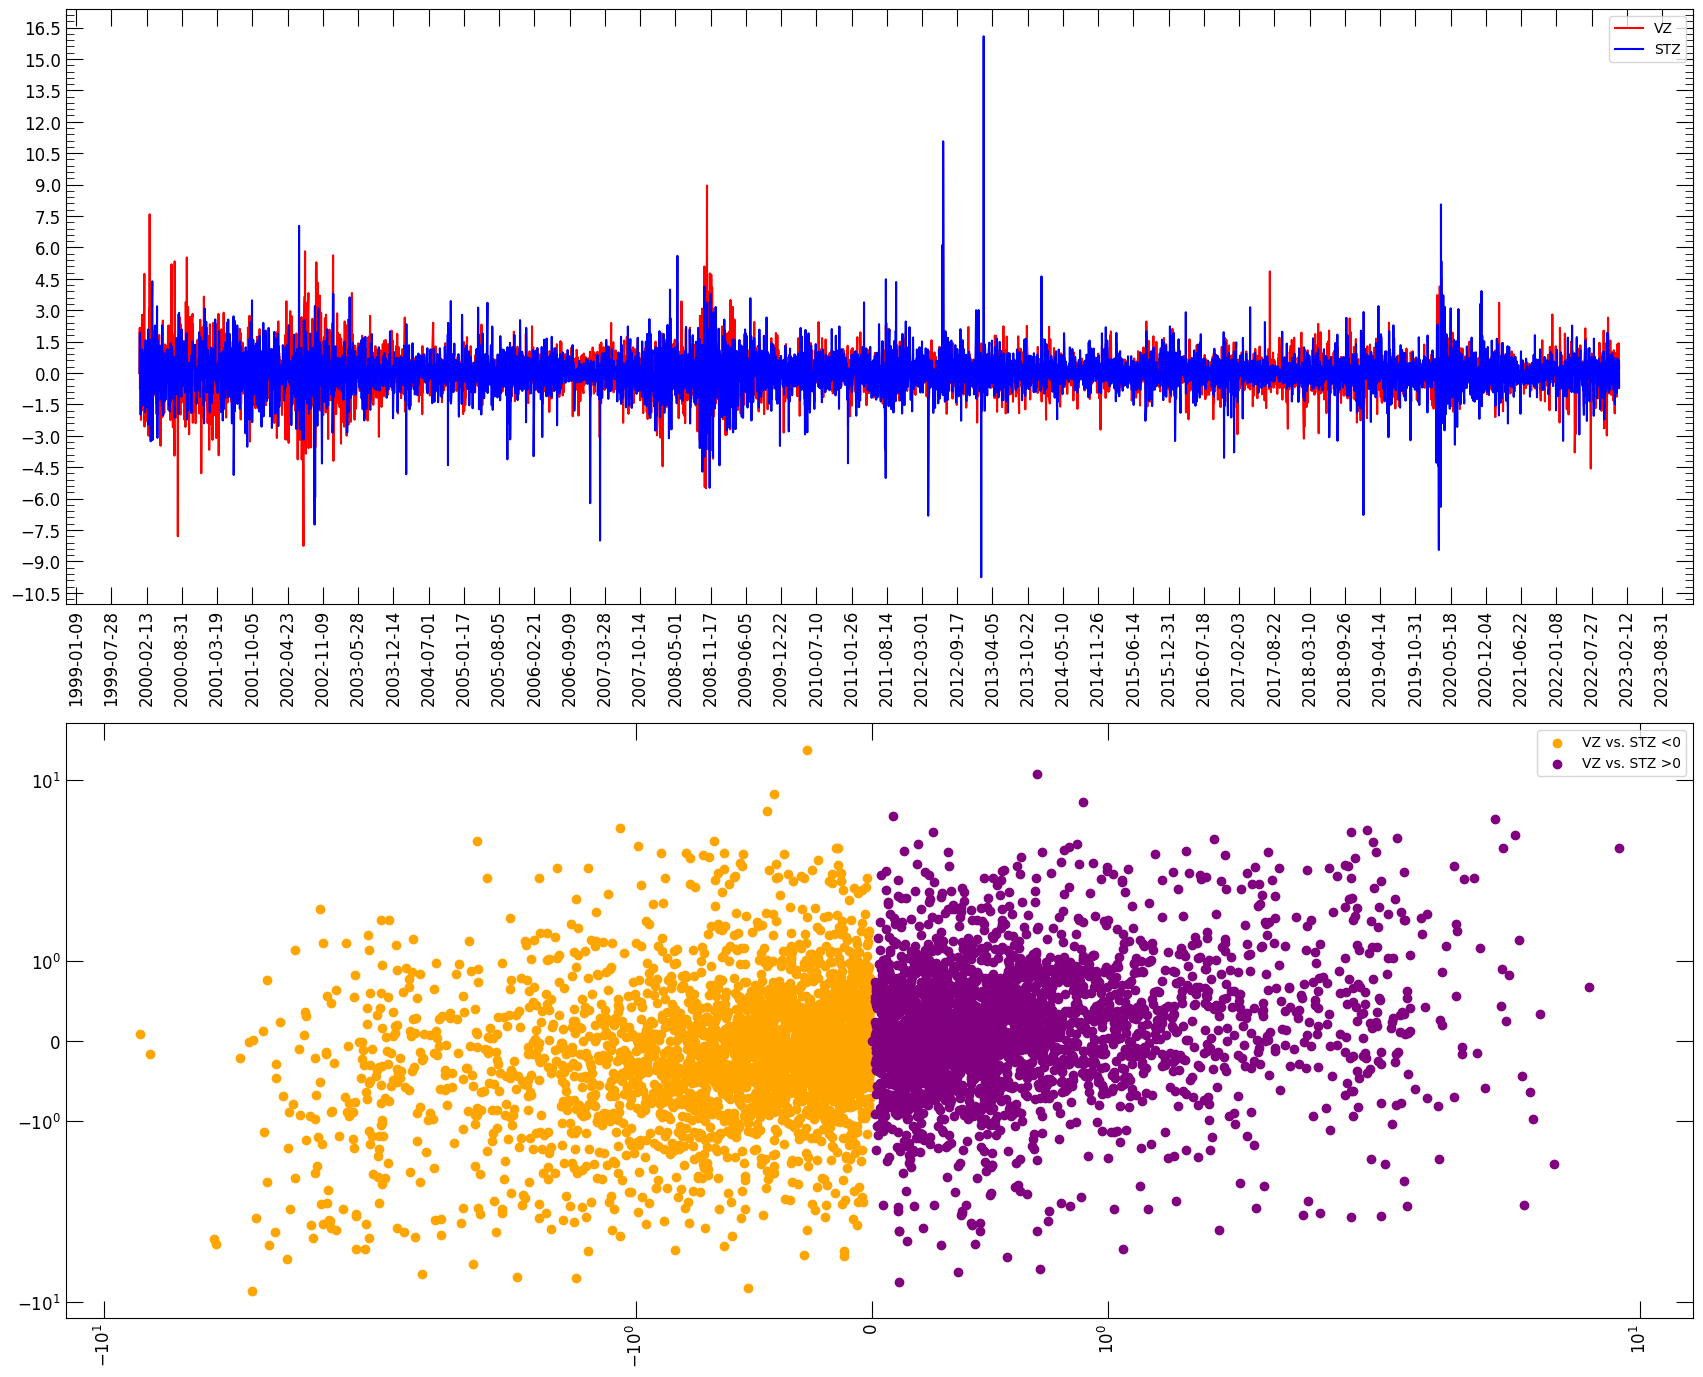

In [55]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

from scipy.optimize import curve_fit # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

s1 = "VZ"
s2 = "STZ"

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == s1]
df_2 = df_stock_index[df_stock_index["symbol"] == s2]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin([s1, s2])]
        .pivot(index = "date", columns = "symbol", values = "normalized_log_return")
        .reset_index()
)
df_3["temp_1"] = df_3[s1]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[s2]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[s1] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1["normalized_log_return"], color = "red", label = s1)
ax[0].plot(df_2["date"], df_2["normalized_log_return"], color = "blue", label = s2)
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(s1, s2))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(s1, s2))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()
